In [2]:
# Install necessary library
!pip install --upgrade mlxtend

# Import libraries
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Step 1: Load the original dataset using a file path
file_path = "/content/Groceries_dataset.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the original data
print("Original Data:")
print(data.head())

# Step 2: Preprocess the data
# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Group transactions by Member_number and Date
transactions = data.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index()
transactions.rename(columns={'itemDescription': 'Items'}, inplace=True)

# Display the transformed dataset
print("\nTransformed Dataset (First 5 Rows):")
print(transactions.head())

# Step 3: Convert to a transactional format for Apriori
transaction_list = transactions['Items'].tolist()

# One-hot encoding using TransactionEncoder
te = TransactionEncoder()
transaction_array = te.fit(transaction_list).transform(transaction_list)
transaction_df = pd.DataFrame(transaction_array, columns=te.columns_)

# Display the first few rows of the transactional DataFrame
print("\nOne-Hot Encoded Transactional Data (First 5 Rows):")
print(transaction_df.head())

# Step 4: Apply Apriori Algorithm
# Using a loop to find the best results if no frequent itemsets are found
min_support_values = [0.01, 0.005, 0.001]
for min_support in min_support_values:
    frequent_itemsets = apriori(transaction_df, min_support=min_support, use_colnames=True)
    if not frequent_itemsets.empty:
        print(f"\nFrequent Itemsets with min_support={min_support} (Top 5):")
        print(frequent_itemsets.head())
        break
else:
    print("\nNo frequent itemsets found. Consider lowering the support threshold further.")
    frequent_itemsets = pd.DataFrame()  # Empty dataframe to prevent further errors

# Step 5: Generate Association Rules
if not frequent_itemsets.empty:
    # Using a loop to adjust confidence thresholds if no rules are found
    min_confidence_values = [0.3, 0.2, 0.1]
    for min_confidence in min_confidence_values:
        try:
            rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
        except TypeError:
            # For older versions of mlxtend requiring num_itemsets
            rules = association_rules(frequent_itemsets, num_itemsets=len(frequent_itemsets), metric="confidence", min_threshold=min_confidence)

        if not rules.empty:
            # Sort rules by lift in descending order
            rules_sorted = rules.sort_values(by="lift", ascending=False)
            print(f"\nTop Association Rules with min_confidence={min_confidence}:")
            print(rules_sorted.head())
            break
    else:
        print("\nNo association rules found with the current thresholds. Consider lowering them further.")
else:
    print("\nSkipping association rule generation as no frequent itemsets were found.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Original Data:
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk

Transformed Dataset (First 5 Rows):
   Member_number       Date                                              Items
0           1000 2014-06-24                  [whole milk, pastry, salty snack]
1           1000 2015-03-15  [sausage, whole milk, semi-finished bread, yog...
2           1000 2015-05-27                         [soda, pickled vegetables]
3           1000 2015-07-24                     [canned beer, misc. beverages]
4           1000 2015-11-25                        [sausage, hygiene articles]

One-Hot Encoded Transactional Data (First 5 Rows):
   Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                  False     False             False             F

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



No high-lift rules found. Lowering thresholds further might help.


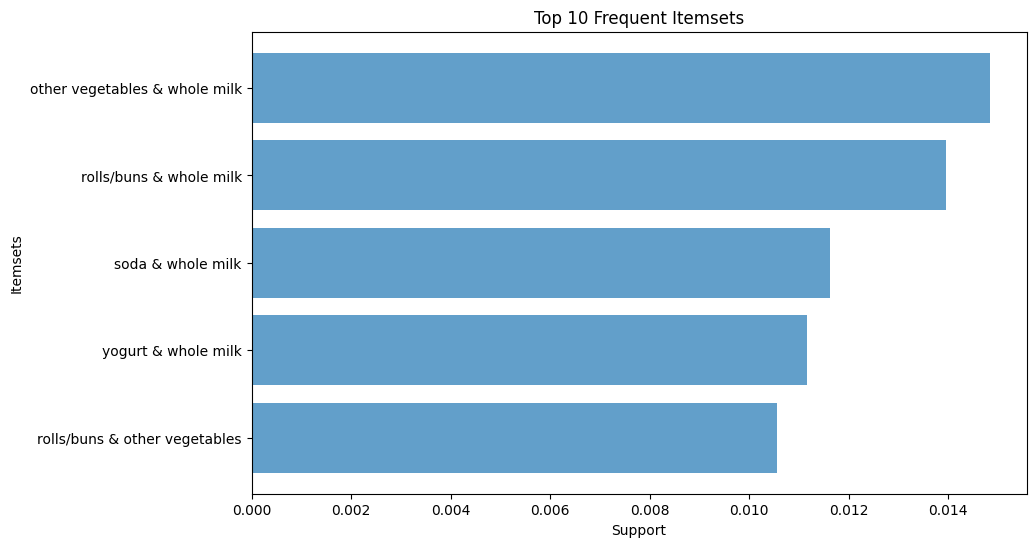


No rules available for network visualization.


In [3]:
import matplotlib.pyplot as plt
import networkx as nx

# Step 1: Filter rules with meaningful lift (> 1)
useful_rules = rules_sorted[rules_sorted['lift'] > 1]

if not useful_rules.empty:
    print("\nHigh-Lift Association Rules:")
    print(useful_rules.head())
else:
    print("\nNo high-lift rules found. Lowering thresholds further might help.")

# Step 2: Visualize frequent itemsets
# Plot top 10 frequent itemsets by support
if not frequent_itemsets.empty:
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    top_itemsets = frequent_itemsets[frequent_itemsets['length'] > 1].sort_values(by="support", ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    plt.barh([" & ".join(list(x)) for x in top_itemsets['itemsets']], top_itemsets['support'], alpha=0.7)
    plt.xlabel('Support')
    plt.ylabel('Itemsets')
    plt.title('Top 10 Frequent Itemsets')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("\nNo frequent itemsets available for visualization.")

# Step 3: Visualize Association Rules as a Network
if not useful_rules.empty:
    G = nx.DiGraph()

    for _, rule in useful_rules.iterrows():
        G.add_edge(", ".join(rule['antecedents']),
                   ", ".join(rule['consequents']),
                   weight=rule['lift'])

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray")

    # Add edge labels for lift
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Association Rules Network (Lift > 1)")
    plt.show()
else:
    print("\nNo rules available for network visualization.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


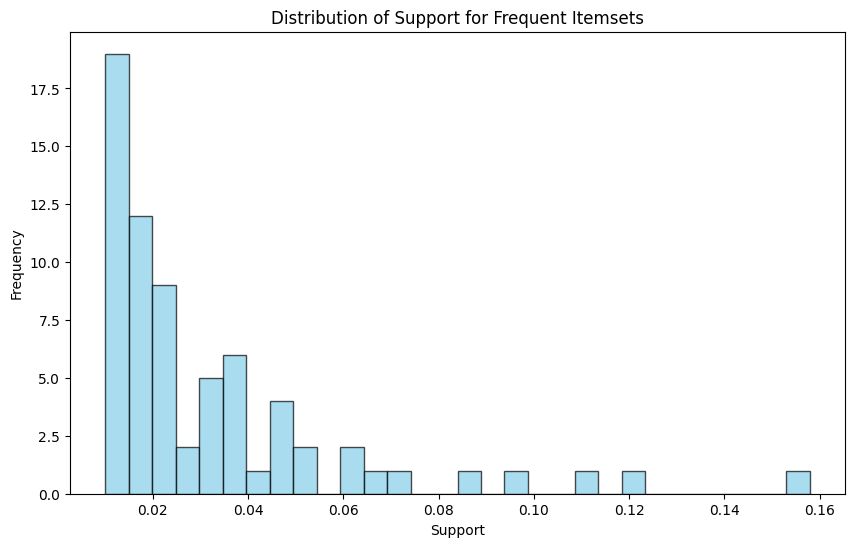

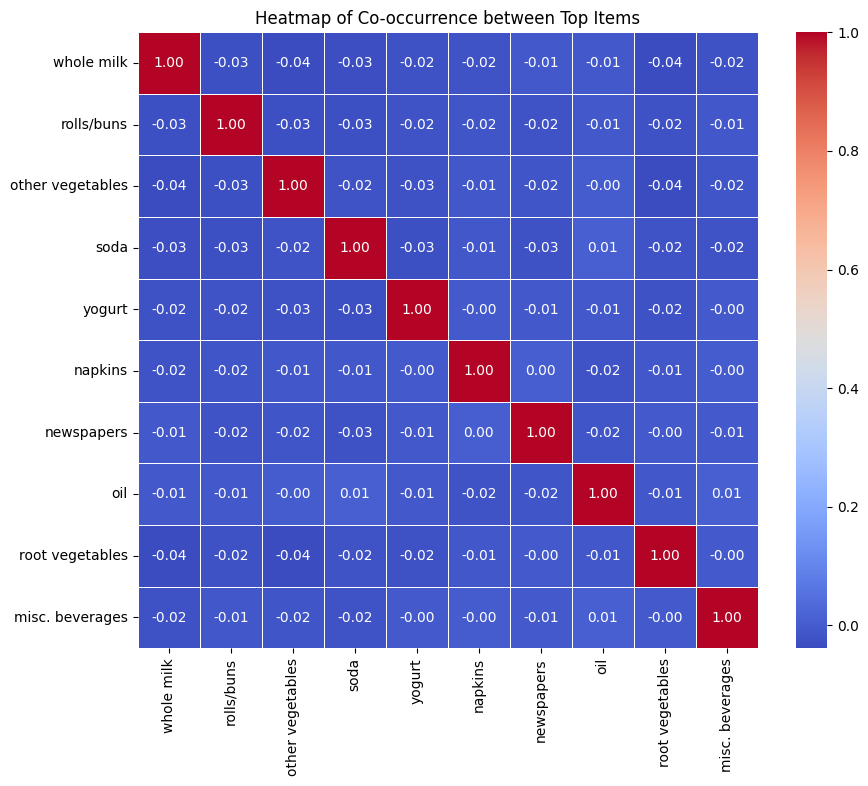

In [6]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Support Distribution of All Frequent Itemsets
plt.figure(figsize=(10, 6))
plt.hist(frequent_itemsets['support'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Support for Frequent Itemsets')
plt.xlabel('Support')
plt.ylabel('Frequency')
plt.show()

# Top Consequent Items
if not useful_rules.empty:
    plt.figure(figsize=(10, 6))
    consequents = useful_rules['consequents'].explode().value_counts().head(10)
    consequents.plot(kind='bar', color='coral', alpha=0.7)
    plt.title('Top 10 Consequent Items')
    plt.xlabel('Items')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Confidence vs Lift Scatter Plot
if not useful_rules.empty:
    plt.figure(figsize=(10, 6))
    plt.scatter(useful_rules['confidence'], useful_rules['lift'], alpha=0.7, color='purple')
    plt.title('Confidence vs Lift for Association Rules')
    plt.xlabel('Confidence')
    plt.ylabel('Lift')
    plt.grid(True)
    plt.show()

# Transaction Heatmap for Top Items
top_items = frequent_itemsets.explode('itemsets')['itemsets'].value_counts().head(10).index.tolist()
top_transactions = transaction_df[top_items].astype(int)
correlation_matrix = top_transactions.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Co-occurrence between Top Items')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


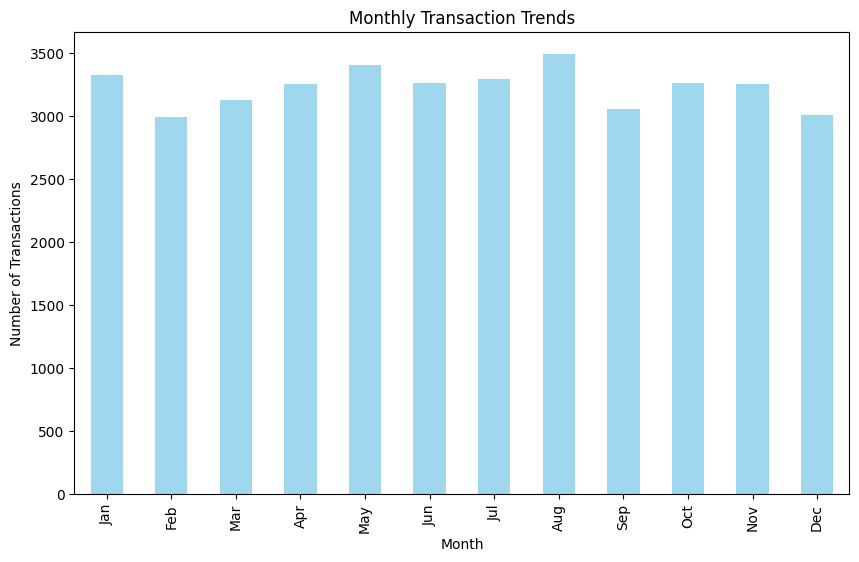

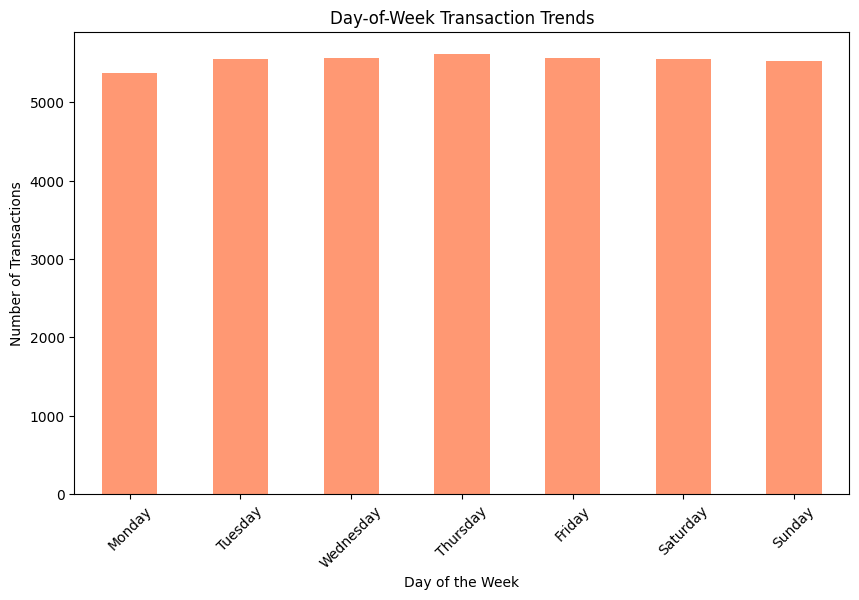

In [7]:
# Add a column for the month and day of the week
data['Month'] = data['Date'].dt.month
data['DayOfWeek'] = data['Date'].dt.day_name()

# Monthly trend analysis
monthly_trends = data.groupby('Month')['itemDescription'].count()

plt.figure(figsize=(10, 6))
monthly_trends.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Monthly Transaction Trends')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Day of the week trend analysis
weekly_trends = data.groupby('DayOfWeek')['itemDescription'].count().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(10, 6))
weekly_trends.plot(kind='bar', color='coral', alpha=0.8)
plt.title('Day-of-Week Transaction Trends')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


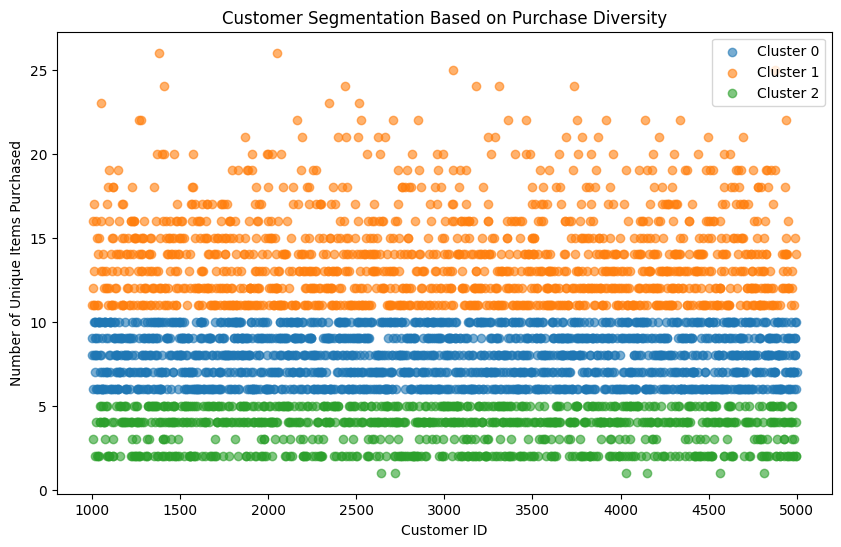

In [8]:
# Aggregate the number of unique items purchased by each customer
customer_item_counts = data.groupby('Member_number')['itemDescription'].nunique()

# Clustering customers based on their purchase diversity
from sklearn.cluster import KMeans
import numpy as np

# Reshape the data for clustering
X = customer_item_counts.values.reshape(-1, 1)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# Add the cluster information to the dataset
customer_segments = pd.DataFrame({'CustomerID': customer_item_counts.index, 'UniqueItems': X.flatten(), 'Cluster': clusters})

# Visualize the clusters
plt.figure(figsize=(10, 6))
for cluster in range(3):
    subset = customer_segments[customer_segments['Cluster'] == cluster]
    plt.scatter(subset['CustomerID'], subset['UniqueItems'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('Customer Segmentation Based on Purchase Diversity')
plt.xlabel('Customer ID')
plt.ylabel('Number of Unique Items Purchased')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-9-03f2d86b7f21>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_items_per_cluster = cluster_item_counts.groupby('Cluster').apply(lambda x: x.nlargest(10, 'Count')).reset_index(drop=True)


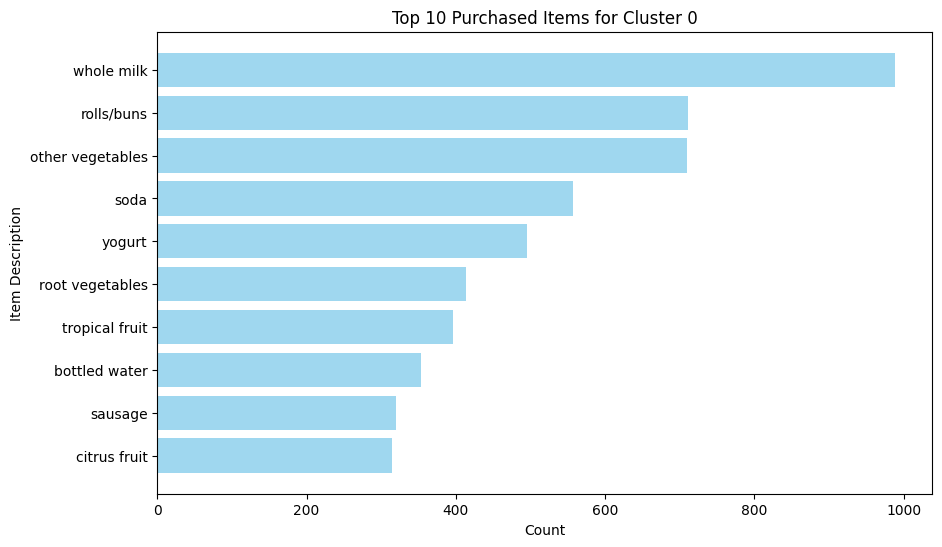

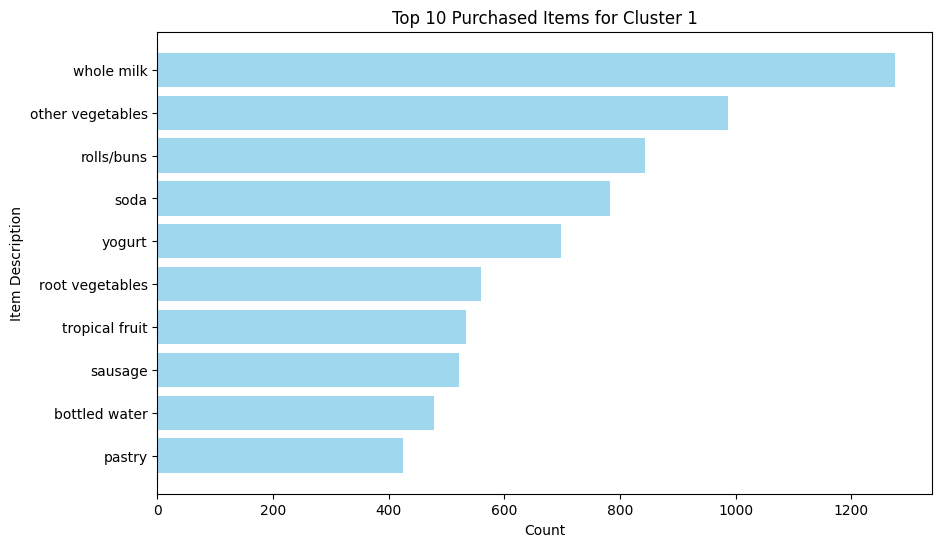

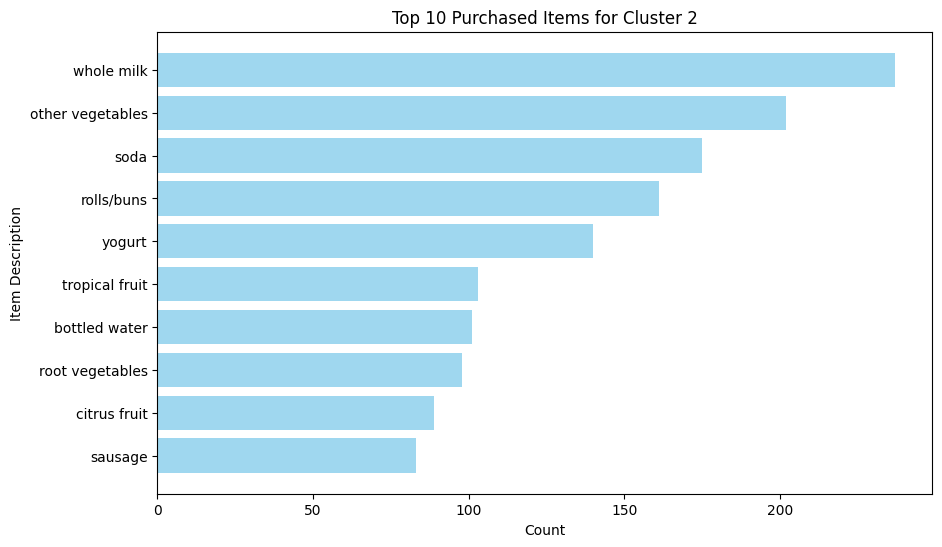

In [9]:
# Merge cluster information back with the original data
data_with_clusters = data.merge(customer_segments, left_on='Member_number', right_on='CustomerID')

# Analyze the top items for each cluster
cluster_item_counts = data_with_clusters.groupby(['Cluster', 'itemDescription']).size().reset_index(name='Count')

# Get the top 10 items for each cluster
top_items_per_cluster = cluster_item_counts.groupby('Cluster').apply(lambda x: x.nlargest(10, 'Count')).reset_index(drop=True)

# Visualize top items for each cluster
for cluster in top_items_per_cluster['Cluster'].unique():
    cluster_data = top_items_per_cluster[top_items_per_cluster['Cluster'] == cluster]
    plt.figure(figsize=(10, 6))
    plt.barh(cluster_data['itemDescription'], cluster_data['Count'], color='skyblue', alpha=0.8)
    plt.title(f'Top 10 Purchased Items for Cluster {cluster}')
    plt.xlabel('Count')
    plt.ylabel('Item Description')
    plt.gca().invert_yaxis()
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1000x600 with 0 Axes>

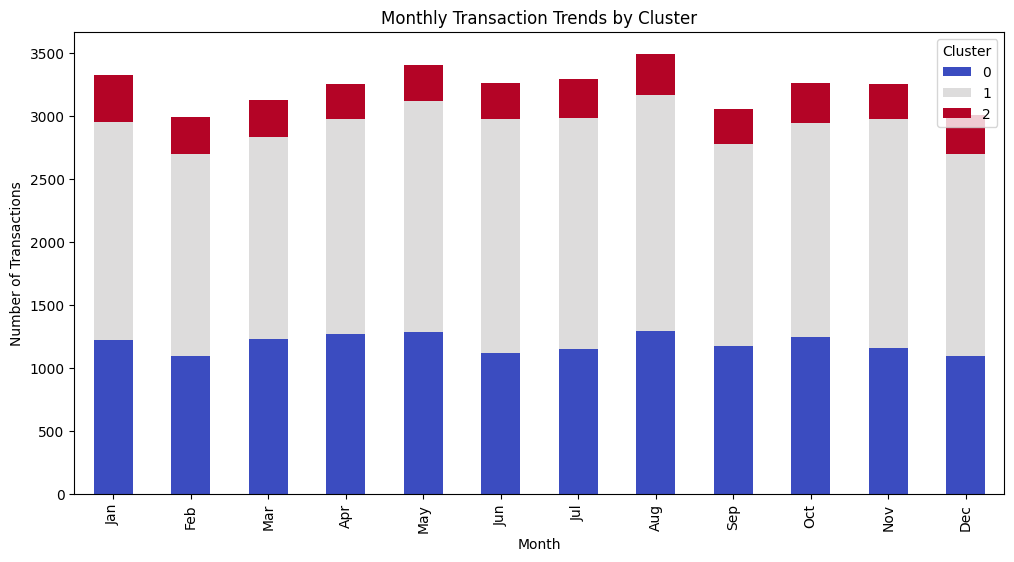

<Figure size 1000x600 with 0 Axes>

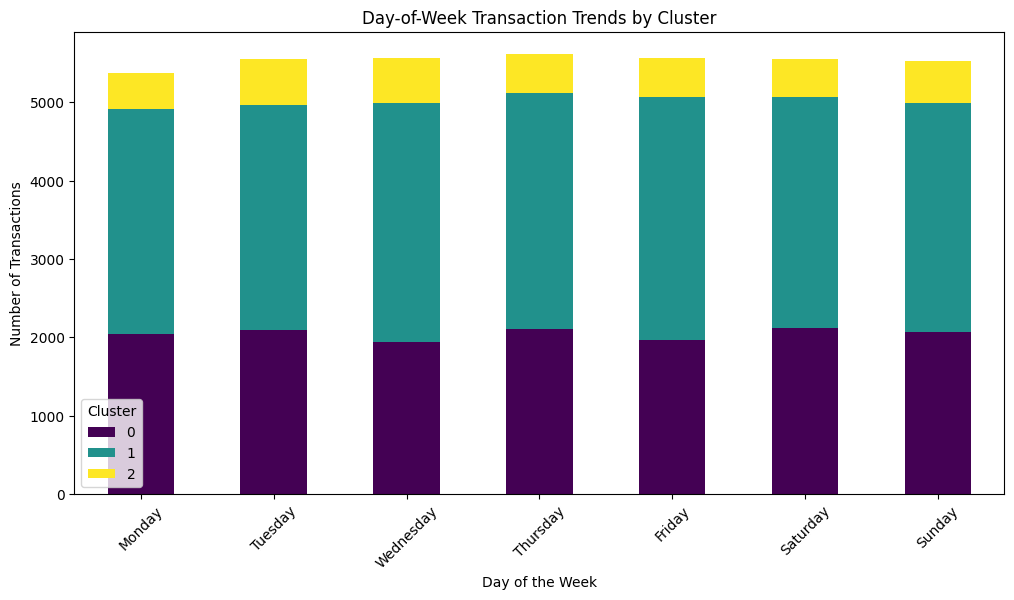

In [10]:
# Monthly trends for each cluster
monthly_cluster_trends = data_with_clusters.groupby(['Cluster', 'Month'])['itemDescription'].count().reset_index()
monthly_cluster_trends_pivot = monthly_cluster_trends.pivot(index='Month', columns='Cluster', values='itemDescription')

plt.figure(figsize=(10, 6))
monthly_cluster_trends_pivot.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12, 6))
plt.title('Monthly Transaction Trends by Cluster')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.legend(title='Cluster')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Day-of-week trends for each cluster
weekly_cluster_trends = data_with_clusters.groupby(['Cluster', 'DayOfWeek'])['itemDescription'].count().reset_index()
weekly_cluster_trends_pivot = weekly_cluster_trends.pivot(index='DayOfWeek', columns='Cluster', values='itemDescription')

plt.figure(figsize=(10, 6))
weekly_cluster_trends_pivot.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title('Day-of-Week Transaction Trends by Cluster')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()
